In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import sys
import numpy as np

sys.path.insert(0, './src/')
from target import NN_bernoulli, GMM_target2
from kernels import HMC_our, HMC_vanilla, Reverse_kernel
%matplotlib inline

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [3]:
# 'Encoder' - simple matrix
class Encoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Encoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.L, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.z_dim)
        self.sigma = nn.Linear(in_features=K, out_features=self.z_dim)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2), F.softplus(self.sigma(h2))
    
class Decoder_vae(nn.Module):
    def __init__(self, L, z_dim):
        super(Decoder_vae, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.h1 = nn.Linear(in_features=self.z_dim, out_features=K)
        self.h2 = nn.Linear(in_features=K, out_features=K)
        self.mu = nn.Linear(in_features=K, out_features=self.L)
#         self.sigma = nn.Linear(in_features=K, out_features=self.L)
    def forward(self, x):
        h1 = F.selu(self.h1(x))
        h2 = F.selu(self.h2(h1))
        return self.mu(h2) #, nn.functional.softplus(self.sigma(h3))

In [4]:
# 'Encoder' - simple matrix
class Encoder_h(nn.Module):
    def __init__(self, L, z_dim, device='cpu'):
        super(Encoder_h, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.mu = nn.Linear(in_features=self.L, out_features=self.z_dim, bias=False)
        self.h = nn.Linear(in_features=self.L, out_features=self.z_dim)
    def forward(self, x):
        return self.mu(x), self.h(x)
    
# 'Encoder' - simple matrix
class Encoder(nn.Module):
    def __init__(self, L, z_dim, device='cpu'):
        super(Encoder, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.mu = nn.Linear(in_features=self.L, out_features=self.z_dim, bias=False)
#         self.sigma = nn.Linear(in_features=self.L, out_features=self.z_dim, bias=False)
    def forward(self, x):
        return self.mu(x) #, F.softplus(self.sigma(x))
    
# 'Decoder' - simple matrix, return logits
class Decoder(nn.Module):
    def __init__(self, L, z_dim, device='cpu'):
        super(Decoder, self).__init__()
        self.L = L
        self.z_dim = z_dim
        self.W = nn.Linear(in_features=self.z_dim, out_features=self.L, bias=False)
    def forward(self, z):
        return self.W(z)

In [5]:
L = 2

K = 1024
z_dim = 64
N = 200

device = "cuda:1" if torch.cuda.is_available() else "cpu"

args = dotdict({})
args.K = 2
args.N = 2
args.z_dim = z_dim
args.torchType = torch.float32
args.device = device
args.learnable_reverse = True
args.learnable_accept = False
args.num_epoches = 2000
args.train_batch_size = 250
args.amortize = False
args.gamma = 0.1 ## Stepsize
args.alpha = 0.5  ## For partial momentum refresh
args.train_only_inference_period = 10
args.train_only_inference_cutoff = 5
args.hoffman_idea = True
args.separate_params = True
args.use_barker = True


std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
args.std_normal = std_normal

In [6]:
true_theta = std_normal.sample((z_dim, L)) + 5
print('True decoder matrix')
print(true_theta)
print('-' * 75)
data_probs = torch.sigmoid(std_normal.sample((N, z_dim)) @ true_theta)
# data_probs = torch.sigmoid(torch.ones((N, z_dim), device=device) @ true_theta)
data = torch.distributions.Bernoulli(probs=data_probs).sample()
print('Generated data example:')
print(data[:10])

True decoder matrix
tensor([[5.0380, 6.0573],
        [4.7091, 5.7090],
        [4.4191, 6.0491],
        [5.0280, 4.9637],
        [5.0299, 5.7748],
        [4.1297, 5.3330],
        [5.2265, 3.4633],
        [4.0772, 4.4436],
        [3.7775, 7.0949],
        [3.6113, 5.6327],
        [3.3003, 5.7616],
        [3.9192, 4.2574],
        [7.3816, 4.6073],
        [5.4668, 5.1611],
        [3.7383, 6.9237],
        [3.1445, 4.8125],
        [6.0124, 5.7015],
        [6.7196, 5.4491],
        [4.5188, 7.3223],
        [4.5646, 5.0594],
        [4.9981, 4.5157],
        [4.0234, 6.2064],
        [4.4774, 5.2004],
        [6.6509, 6.5912],
        [4.2398, 4.3358],
        [5.5225, 4.1688],
        [3.7823, 4.1581],
        [4.9524, 6.5177],
        [6.9682, 4.6370],
        [4.7150, 4.5377],
        [6.2944, 6.7924],
        [6.8897, 4.5797],
        [4.7737, 4.3711],
        [4.5199, 5.2169],
        [5.3362, 6.5610],
        [4.8693, 5.5642],
        [3.7797, 5.8671],
        [4.7947, 5

In [7]:
# GMM with arbitraty many components
comp_1 = 1
comp_2 = 0.7
args['num_gauss'] = 8
args['p_gaussians'] = [torch.tensor(1. / args['num_gauss'], device=args.device, dtype=args.torchType)] * args['num_gauss']
args['locs'] = [torch.tensor([0., comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([0., -comp_1], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, -comp_2], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_1, 0.], dtype=args.torchType, device=args.device),
               torch.tensor([-comp_2, comp_2], dtype=args.torchType, device=args.device)]  # list of locations for each of these gaussians
args['covs'] = [0.01 * torch.eye(2, dtype=args.torchType, device=args.device)] * args['num_gauss']   # list of covariance matrices for each of these

target = GMM_target2(args, device)
data = target.get_samples(1000)

In [8]:
# plt.scatter(data[:, 0].cpu(), data[:, 1].cpu())
# plt.axis('equal');

In [9]:
dataloader = torch.utils.data.DataLoader(data, batch_size=args.train_batch_size, shuffle=True)

In [10]:
def potential_fn(z):
    z = z['points']
#     pdb.set_trace()
    potential = -target.get_logdensity(z).sum()
    return potential
        
    
init_samples = std_normal.sample((100, 2))
init_params = {'points': init_samples}

nuts_kernel = NUTS(potential_fn=potential_fn)
mcmc = MCMC(nuts_kernel,
            initial_params=init_params,
            num_samples=1,
            warmup_steps=1000)

mcmc.run()
z = mcmc.get_samples()['points'].squeeze()

Sample: 100%|██████████| 1001/1001 [02:04,  8.04it/s, step size=1.27e-01, acc. prob=0.842]


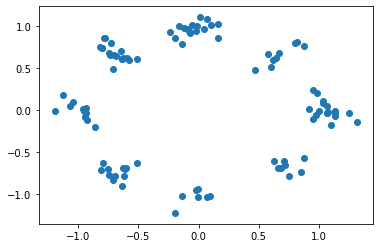

In [11]:
plt.scatter(z[:, 0].cpu(), z[:, 1].cpu())

## NUTS

In [12]:
# def model():
# #     pdb.set_trace()
#     theta = pyro.sample('theta', dist.Normal(torch.zeros((z_dim, L)), torch.ones((z_dim, L))))
#     z = pyro.sample('z', dist.Normal(torch.zeros((data.shape[0], z_dim)), torch.zeros((data.shape[0], z_dim))))
#     probs = torch.sigmoid(z @ theta)
# #     with pyro.plate('obs_plate'):
#     return pyro.sample("obs", dist.Bernoulli(probs=probs), obs=data)
def potential_fn(z):
    z = z['points']
    probs = torch.sigmoid(z @ current_matrix)
    return -torch.mean(torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1))
#     mu_recovered = dec(z)
#     return -(torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).sum(1) + std_normal.log_prob(z).sum(1)).sum()
        

Sample: 100%|██████████| 110/110 [00:05, 18.45it/s, step size=1.65e-01, acc. prob=0.853]


-2.371816039085388


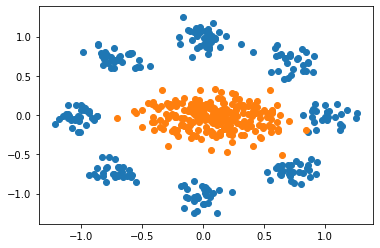

Sample: 100%|██████████| 110/110 [00:03, 35.53it/s, step size=2.15e-01, acc. prob=0.759]


-2.359822690486908


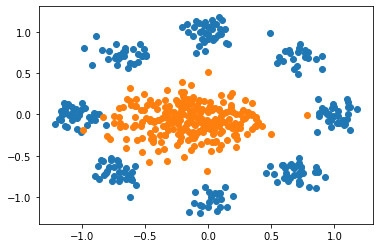

Sample: 100%|██████████| 110/110 [00:06, 17.34it/s, step size=1.69e-01, acc. prob=0.874]


-2.362174153327942


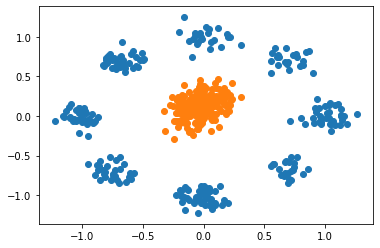

Sample: 100%|██████████| 110/110 [00:06, 17.83it/s, step size=1.92e-01, acc. prob=0.813]


-2.3584015369415283


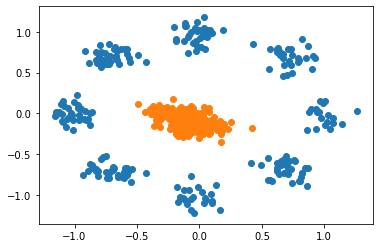

Sample: 100%|██████████| 110/110 [00:06, 17.21it/s, step size=1.56e-01, acc. prob=0.880]


-2.3538156747817993


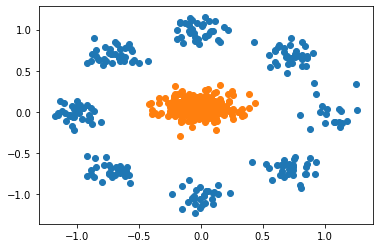

Sample: 100%|██████████| 110/110 [00:06, 17.85it/s, step size=1.73e-01, acc. prob=0.865]


-2.3545907139778137


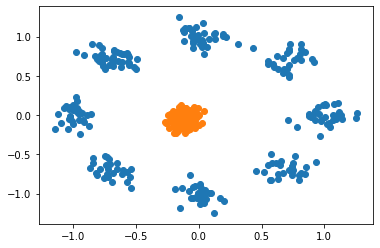

Sample: 100%|██████████| 110/110 [00:06, 17.42it/s, step size=1.24e-01, acc. prob=0.925]


-2.3504149317741394


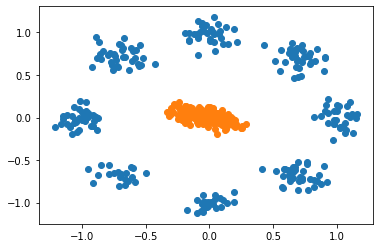

Sample: 100%|██████████| 110/110 [00:06, 17.18it/s, step size=1.61e-01, acc. prob=0.890]


-2.3499221801757812


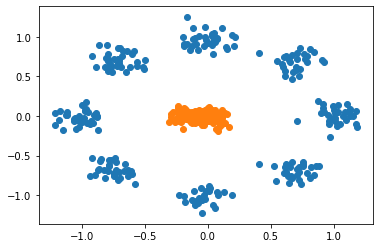

Sample: 100%|██████████| 110/110 [00:06, 17.24it/s, step size=1.59e-01, acc. prob=0.879]


-2.351473391056061


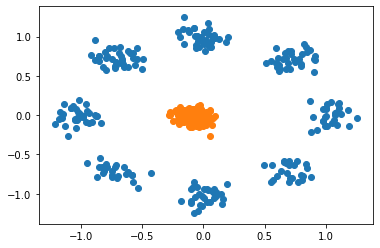

Sample: 100%|██████████| 110/110 [00:07, 15.59it/s, step size=1.57e-01, acc. prob=0.881]


-2.3527852296829224


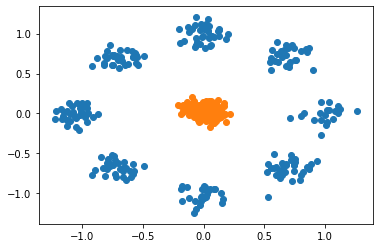

Sample: 100%|██████████| 110/110 [00:03, 34.34it/s, step size=2.30e-01, acc. prob=0.780]


-2.354343295097351


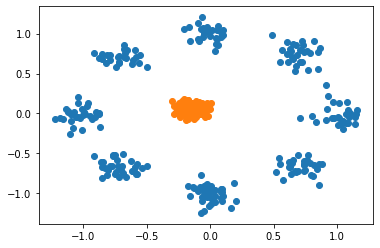

Sample: 100%|██████████| 110/110 [00:06, 17.74it/s, step size=1.95e-01, acc. prob=0.801]


-2.354975938796997


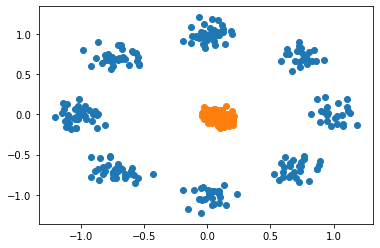

Sample: 100%|██████████| 110/110 [00:06, 17.68it/s, step size=1.99e-01, acc. prob=0.837]


-2.3571093678474426


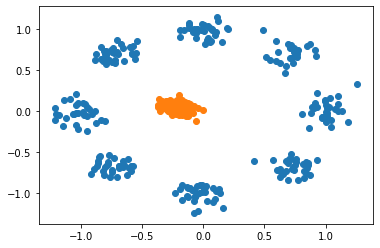

Sample: 100%|██████████| 110/110 [00:06, 17.04it/s, step size=1.31e-01, acc. prob=0.911]


-2.353442430496216


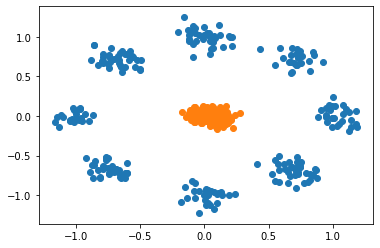

Sample: 100%|██████████| 110/110 [00:06, 17.71it/s, step size=1.52e-01, acc. prob=0.884]


-2.3530901670455933


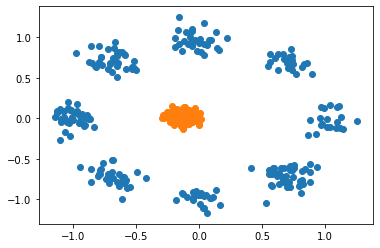

Sample: 100%|██████████| 110/110 [00:07, 15.29it/s, step size=1.89e-01, acc. prob=0.836]


-2.3555094599723816


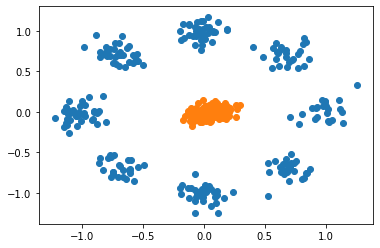

Sample: 100%|██████████| 110/110 [00:06, 17.48it/s, step size=1.79e-01, acc. prob=0.870]


-2.355624496936798


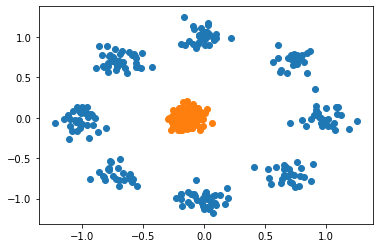

Sample: 100%|██████████| 110/110 [00:06, 17.66it/s, step size=1.97e-01, acc. prob=0.800]


-2.3558566570281982


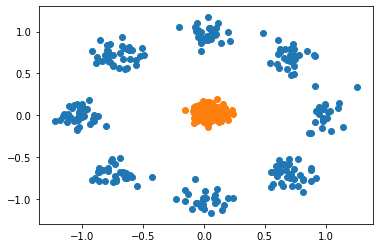

Sample: 100%|██████████| 110/110 [00:03, 33.89it/s, step size=2.58e-01, acc. prob=0.721]


-2.354258716106415


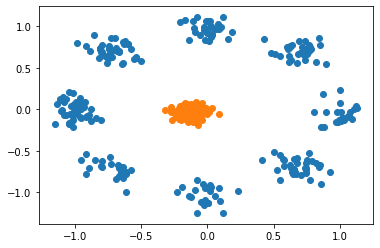

Sample: 100%|██████████| 110/110 [00:08, 13.43it/s, step size=1.08e-01, acc. prob=0.935]


-2.3516827821731567


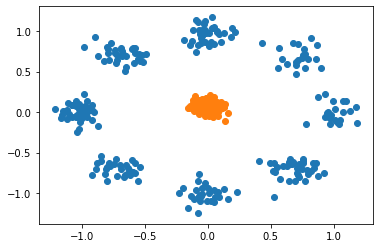

Sample: 100%|██████████| 110/110 [01:25,  1.28it/s, step size=2.05e-01, acc. prob=0.725]

-2.3518092036247253


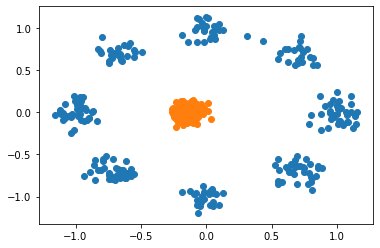

Sample: 100%|██████████| 110/110 [00:06, 18.06it/s, step size=1.93e-01, acc. prob=0.832]


-2.353329300880432


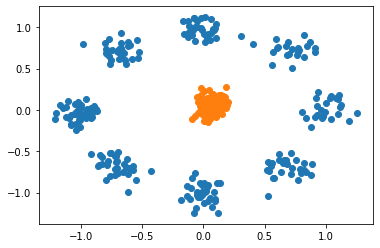

Sample: 100%|██████████| 110/110 [00:06, 17.84it/s, step size=1.93e-01, acc. prob=0.815]


-2.3509504795074463


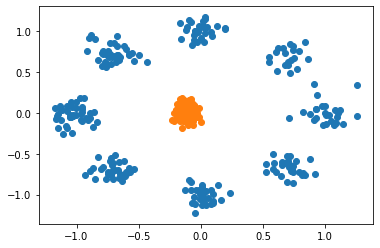

Sample: 100%|██████████| 110/110 [00:06, 17.91it/s, step size=1.80e-01, acc. prob=0.845]


-2.352876603603363


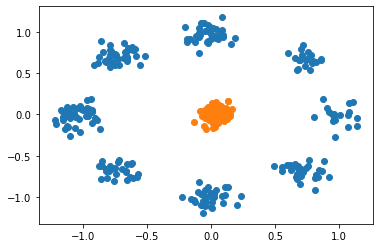

Sample: 100%|██████████| 110/110 [00:03, 33.95it/s, step size=2.22e-01, acc. prob=0.811]


-2.352452576160431


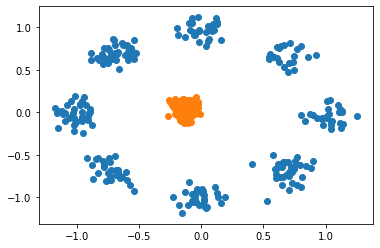

Sample: 100%|██████████| 110/110 [00:06, 17.58it/s, step size=1.84e-01, acc. prob=0.859]


-2.3535540103912354


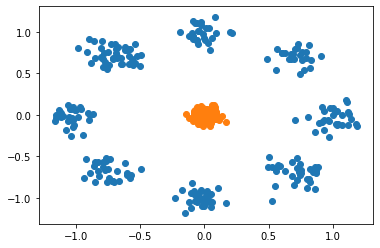

Sample: 100%|██████████| 110/110 [00:07, 15.34it/s, step size=1.56e-01, acc. prob=0.886]


-2.3545300364494324


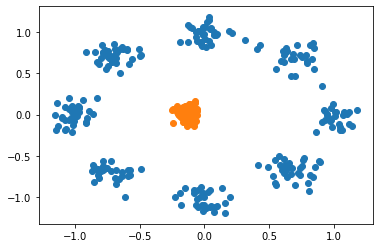

Sample: 100%|██████████| 110/110 [00:06, 17.60it/s, step size=1.52e-01, acc. prob=0.897]


-2.3517303466796875


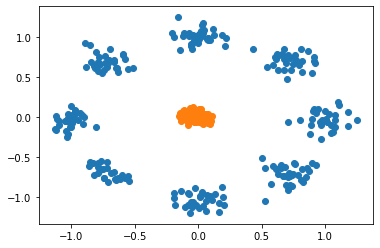

Sample: 100%|██████████| 110/110 [00:06, 17.69it/s, step size=1.83e-01, acc. prob=0.845]


-2.3517144322395325


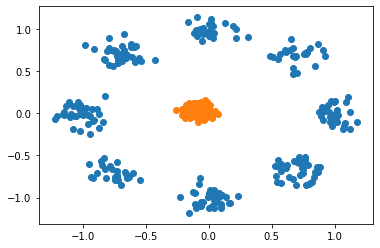

Sample: 100%|██████████| 110/110 [00:06, 17.26it/s, step size=1.59e-01, acc. prob=0.874]


-2.3516774773597717


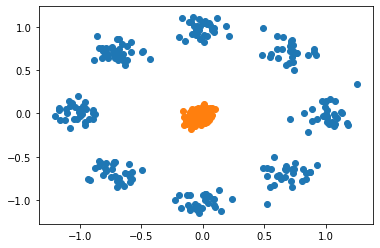

Sample: 100%|██████████| 110/110 [00:06, 17.82it/s, step size=1.76e-01, acc. prob=0.856]


-2.3542860746383667


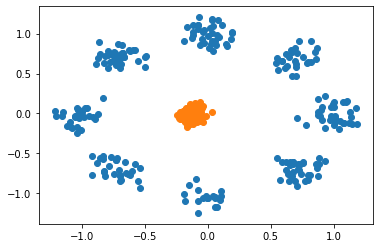

Sample: 100%|██████████| 110/110 [00:03, 35.23it/s, step size=2.12e-01, acc. prob=0.782]


-2.350672721862793


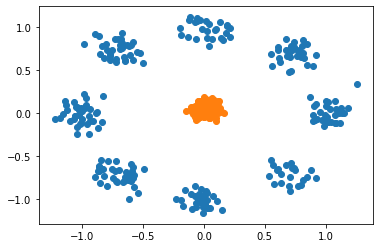

Sample: 100%|██████████| 110/110 [00:03, 34.53it/s, step size=2.77e-01, acc. prob=0.649]


-2.350401759147644


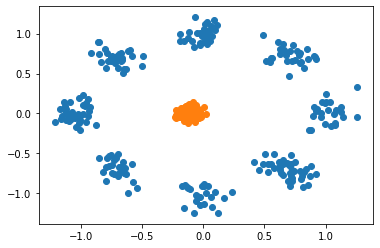

Sample: 100%|██████████| 110/110 [00:06, 17.54it/s, step size=1.51e-01, acc. prob=0.903]


-2.3486889600753784


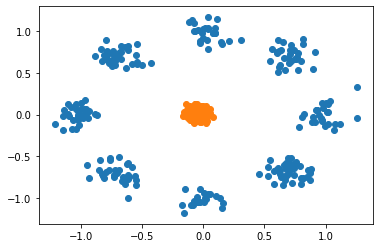

Sample: 100%|██████████| 110/110 [00:06, 17.77it/s, step size=1.80e-01, acc. prob=0.857]


-2.3511303663253784


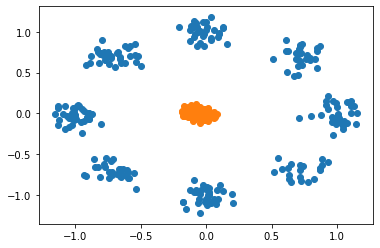

Sample: 100%|██████████| 110/110 [00:06, 17.75it/s, step size=1.97e-01, acc. prob=0.815]


-2.349227726459503


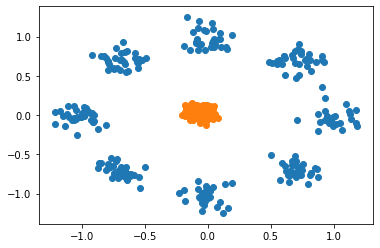

Sample: 100%|██████████| 110/110 [00:06, 18.23it/s, step size=1.64e-01, acc. prob=0.867]


-2.350393235683441


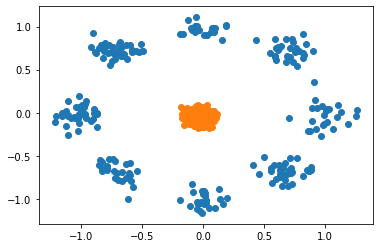

Sample: 100%|██████████| 110/110 [00:06, 17.31it/s, step size=1.48e-01, acc. prob=0.891]


-2.3490198254585266


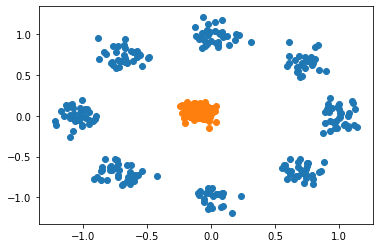

Sample: 100%|██████████| 110/110 [00:06, 17.87it/s, step size=1.81e-01, acc. prob=0.878]


-2.3498584032058716


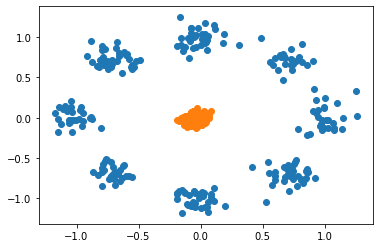

Sample: 100%|██████████| 110/110 [00:03, 34.19it/s, step size=2.21e-01, acc. prob=0.779]


-2.3508307337760925


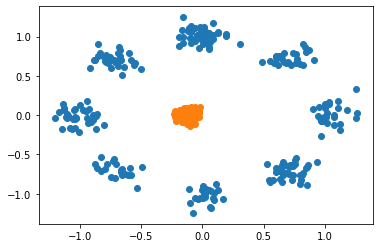

Sample: 100%|██████████| 110/110 [00:08, 13.41it/s, step size=1.39e-01, acc. prob=0.924]


-2.3516510128974915


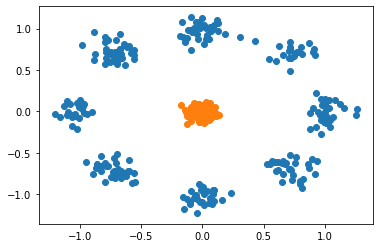

Sample: 100%|██████████| 110/110 [00:03, 35.21it/s, step size=2.81e-01, acc. prob=0.636]


-2.3504892587661743


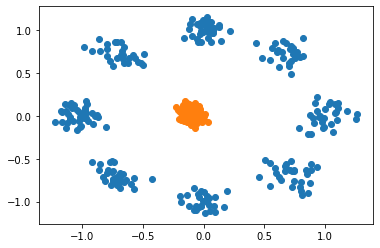

Sample: 100%|██████████| 110/110 [00:07, 13.91it/s, step size=2.00e-01, acc. prob=0.795]


-2.3507702946662903


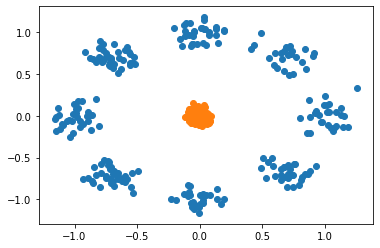

Sample: 100%|██████████| 110/110 [00:06, 16.73it/s, step size=1.70e-01, acc. prob=0.882]


-2.3508219122886658


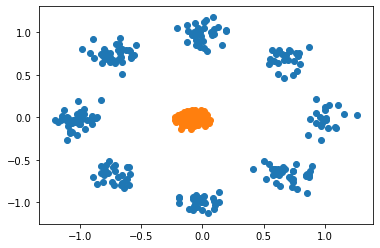

Sample: 100%|██████████| 110/110 [00:06, 17.18it/s, step size=1.79e-01, acc. prob=0.846]


-2.3498950600624084


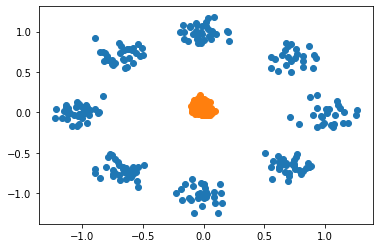

Sample: 100%|██████████| 110/110 [00:06, 16.90it/s, step size=1.81e-01, acc. prob=0.862]


-2.348962724208832


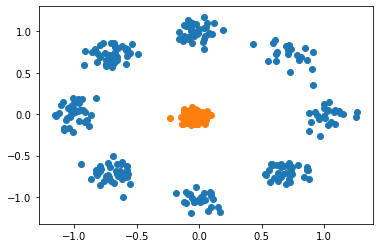

Sample: 100%|██████████| 110/110 [00:06, 15.73it/s, step size=1.50e-01, acc. prob=0.903]


-2.349643349647522


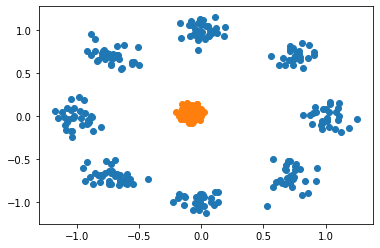

Sample: 100%|██████████| 110/110 [00:04, 27.04it/s, step size=2.27e-01, acc. prob=0.785]


-2.3509247303009033


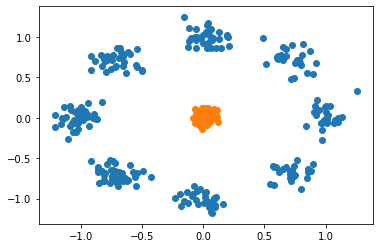

Sample: 100%|██████████| 110/110 [00:06, 16.89it/s, step size=1.99e-01, acc. prob=0.797]


-2.3493860960006714


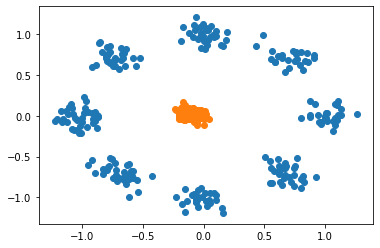

Sample: 100%|██████████| 110/110 [00:06, 17.27it/s, step size=1.92e-01, acc. prob=0.867]


-2.352665364742279


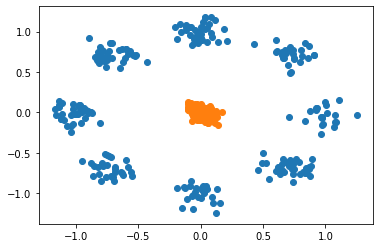

Sample: 100%|██████████| 110/110 [00:06, 17.77it/s, step size=1.55e-01, acc. prob=0.902]


-2.356269359588623


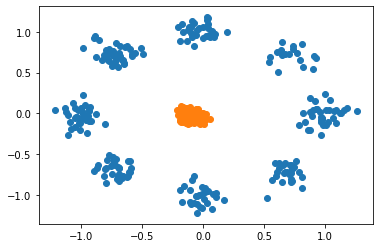

Sample:  56%|█████▋    | 62/110 [00:03, 17.56it/s, step size=1.87e-01, acc. prob=0.848]

KeyboardInterrupt: 

In [12]:
dec = Decoder(L=L, z_dim=z_dim).to(device)
# dec = Decoder_vae(L=L, z_dim=z_dim).to(device)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
optimizer = torch.optim.Adam(params=dec.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')

print_info_ = 1
n_samples = 100

# transitions = nn.ModuleList([HMC_vanilla(args) for _ in range(args.K)])

# class Target():
#     def __init__(self,):
#         pass
#     def get_logdensity(self, z, x):
# #         pdb.set_trace()
#         mu_recovered = dec(z)
#         return (torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(x).sum(1) + std_normal.log_prob(z).sum(1)).sum()

# target = Target()
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    plt.close()
    j = 0
    obj_sum = 0
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        
        init_samples = std_normal.sample((batch_train.shape[0], z_dim))
#         p = std_normal.sample((batch_train.shape[0], z_dim))
#         z = init_samples
#         pdb.set_trace()
#         for k in range(args.K):
#             z, p, _, _, _, _ = transitions[k].make_transition(z, p, target, x=batch_train)
        init_params = {'points': init_samples}
        
        current_matrix = dec.W.weight.detach().T
        
        nuts_kernel = NUTS(potential_fn=potential_fn)
        mcmc = MCMC(nuts_kernel,
                    initial_params=init_params,
                    num_samples=n_samples,
                    warmup_steps=10)
        
#         for p in dec.parameters():
#             p.requires_grad_(False)

        mcmc.run()
        z = mcmc.get_samples()['points'][-n_samples:]
        
#         for p in dec.parameters():
#             p.requires_grad_(True)
        
#         pdb.set_trace()
#         probs = torch.sigmoid(dec(z))
#         obj = torch.mean((torch.distributions.Bernoulli(probs=probs).log_prob(batch_train).mean(0).sum(1)))

        mu_recovered = dec(z)
        obj = (torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean(0).sum(1)).mean()
#         obj = (torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).sum(1)).mean()
        (-obj).backward()
        optimizer.step()
        optimizer.zero_grad()
        
        j += 1
        obj_sum += obj.cpu().detach().numpy()
    scheduler.step(obj)
    if ep % print_info_ == 0:
        print(obj_sum / j)
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[-1, :, 0], mu_recovered.cpu().detach().numpy()[-1, :, 1])
#         plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show()

In [13]:
(torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean(0).sum(1)).mean()

tensor(-2.3831, device='cuda:1', grad_fn=<MeanBackward0>)

In [15]:
(torch.distributions.Normal(loc=batch_train, scale=torch.ones_like(batch_train)).log_prob(batch_train).sum(1)).mean()

tensor(-1.8379, device='cuda:1')

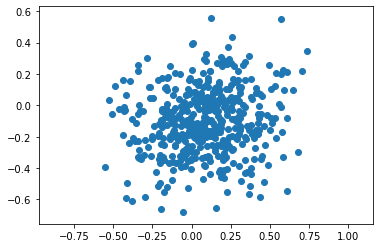

In [20]:
u = args.std_normal.sample((500, args.z_dim)) # sample random tensor for reparametrization trick
batch_recovered = dec(u).cpu().detach().numpy()

plt.scatter(batch_recovered[:, 0], batch_recovered[:, 1])
plt.axis('equal');

In [ ]:
# target_samples = torch.cat([target_samples, mcmc.get_samples()['points']], dim=0)
# target_samples = target_samples.squeeze().cpu()

print(mcmc.get_samples()['points'][-1])
print(true_theta)

In [ ]:
test = torch.arange(30).view(3, 5, 2)
test

In [ ]:
test.view(3, 10).view()

## VAE

  0%|          | 0/2000 [00:00<?, ?it/s]

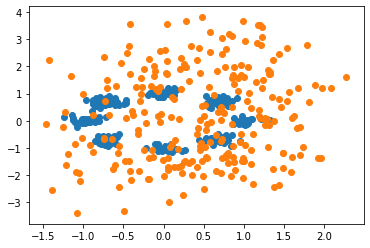

  0%|          | 8/2000 [00:00<03:04, 10.80it/s]

elbo: -2.300258159637451


 25%|██▍       | 496/2000 [00:07<00:21, 69.91it/s]

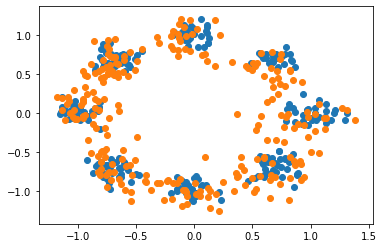

 26%|██▌       | 511/2000 [00:07<00:24, 60.11it/s]

elbo: -0.97517991065979


 50%|████▉     | 994/2000 [00:14<00:14, 70.81it/s]

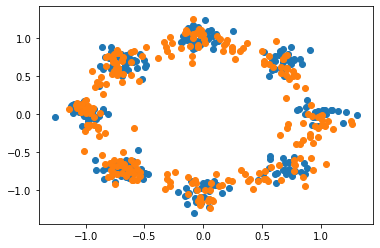

 50%|█████     | 1010/2000 [00:14<00:16, 61.64it/s]

elbo: -0.9741235375404358


 75%|███████▍  | 1494/2000 [00:21<00:07, 69.86it/s]

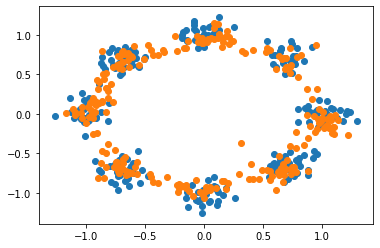

 75%|███████▌  | 1508/2000 [00:21<00:08, 59.81it/s]

elbo: -0.9724735021591187


100%|██████████| 2000/2000 [00:29<00:00, 68.95it/s]


In [10]:
enc = Encoder_vae(L=L, z_dim=z_dim).to(device)
dec = Decoder_vae(L=L, z_dim=z_dim).to(device)

# enc = Encoder(L=L, z_dim=z_dim).to(device)
# dec = Decoder(L=L, z_dim=z_dim).to(device)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device),
                                                scale=torch.tensor(1., device=device))
args.std_normal = std_normal

params = list(enc.parameters()) + list(dec.parameters())
optimizer = torch.optim.Adam(params=params, lr=1e-3)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500, 2000, 2500,
#                                                                        3000, 3500, 4000, 4500], gamma=0.9) #torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1e-2, eps=1e-6, mode='max')


print_info_ = 500
# with torch.autograd.detect_anomaly():
for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    plt.close()
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
#         pdb.set_trace()   
        mu, sigma = enc(batch_train) # sample mu and sigma from encoder
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u * sigma # reperametrization trick
        
        mu_recovered = dec(z)
        log_likelihood = torch.distributions.Normal(loc=mu_recovered, scale=torch.ones_like(mu_recovered)).log_prob(batch_train).mean()
#         log_likelihood = torch.distributions.Bernoulli(probs=torch.sigmoid(mu_recovered)).log_prob(batch_train).sum(1)
    
#         sum_log_sigma = torch.sum(torch.log(sigma), 1)
#         log_prior = std_normal.log_prob(z).sum(1)
#         log_q = std_normal.log_prob((z - mu) / sigma).sum(1) - sum_log_sigma
#         elbo = torch.mean(log_likelihood + log_prior - log_q)

        KLD = -0.5 * torch.mean(1 + 2 * sigma.log() - mu.pow(2) - sigma.pow(2))
        elbo = log_likelihood - KLD
        
        
        (-elbo).backward()
        
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step(elbo)
    if ep % print_info_ == 0:
        plt.scatter(batch_train.cpu().detach().numpy()[:, 0], batch_train.cpu().detach().numpy()[:, 1])
        plt.scatter(mu_recovered.cpu().detach().numpy()[:, 0], mu_recovered.cpu().detach().numpy()[:, 1])
        plt.show()
        print('elbo:', elbo.cpu().detach().item())

In [11]:
print(dec.W.weight.T)
print(true_theta)

AttributeError: 'Decoder_vae' object has no attribute 'W'

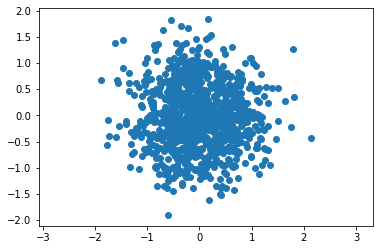

In [12]:
u = args.std_normal.sample((1000, args.z_dim)) # sample random tensor for reparametrization trick
batch_recovered = dec(u).cpu().detach().numpy()

plt.scatter(batch_recovered[:, 0], batch_recovered[:, 1])
plt.axis('equal');

In [ ]:
[p for p in optimizer.parameters()]

In [5]:
if args.learnable_reverse:
    enc = Encoder_h(L=L, z_dim=z_dim, device=device).to(device)
else:
    enc = Encoder(L=L, z_dim=z_dim, device=device).to(device)
dec = Decoder(L=L, z_dim=z_dim, device=device).to(device)
reverse_kernel = Reverse_kernel(args).to(device)
target = NN_bernoulli({}, dec, device).to(device)
transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])

In [7]:
if args.learnable_reverse:
    reverse_params = list(reverse_kernel.parameters())
else:
    reverse_params = list([])
    
if args.learnable_accept:
    accept_func = Accept_func(kwargs=args).to(args.device)
    accept_params = accept_func.parameters()
else:
    accept_params = list([])

if args.separate_params:
    params_inference = list(enc.parameters()) + list(reverse_kernel.parameters()) + list(transitions.parameters()) + accept_params
    optimizer = torch.optim.Adam(params=target.parameters())
    optimizer_inference = torch.optim.Adam(params=params_inference)
else:
    params = list(enc.parameters()) + list(target.parameters()) + list(transitions.parameters()) + reverse_params + accept_params
    optimizer = torch.optim.Adam(params=params)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200, 300, 400], gamma=0.5) #torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0, last_epoch=-1)

In [8]:
enc.mu.weight

Parameter containing:
tensor([[-0.2717, -0.6099],
        [-0.5089, -0.2191]], requires_grad=True)

In [9]:
def compute_loss(z_new, p_new, u, p_old, x, sum_log_alpha, sum_log_jac, sum_log_sigma=0., mu=None, all_directions=None, h=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=z_new.detach(), h=h.detach(), a=all_directions)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
    else:
        log_r = -args.K * torch.tensor(np.log(2.), device=device)
        log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac - sum_log_sigma + sum_log_alpha
        
    log_p = target.get_logdensity(z=z_new, x=x, args=args) + args.std_normal.log_prob(p_new.sum(1))
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full, grad_elbo 

In [10]:
print_info_ = 500

for ep in tqdm(range(args.num_epoches)): # cycle over epoches
    for b_num, batch_train in enumerate(dataloader): # cycle over batches
        if args.learnable_reverse:
            mu, h = enc(batch_train) # sample mu and sigma from encoder
        else:
            mu = enc(batch_train) # sample mu and sigma from encoder
            h = None
        u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
        z = mu + u # reperametrization trick

        p_old = args.std_normal.sample(z.shape)
        cond_vectors = [args.std_normal.sample(p_old.shape) for _ in range(args.K)]

        sum_log_alpha = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
        sum_log_jacobian = torch.zeros(mu.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
        p = p_old
        if args.learnable_reverse:
            all_directions = torch.tensor([], device=args.device)
        else:
            all_directions = None
        for k in range(args.K):
            # sample alpha - transition probabilities 
            if args.amortize:
#                     pdb.set_trace()
                z, p, log_jac, current_log_alphas, directions, _ = transitions.make_transition(q_old=z, x=batch_train,
                                                    p_old=p, k=cond_vectors[k], target_distr=target, args=args)
            else:
                z, p, log_jac, current_log_alphas, directions, _ = transitions[k].make_transition(q_old=z, x=batch_train,
                                                                    p_old=p, k=cond_vectors[k], target_distr=target, args=args) # sample a_i -- directions
            if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
                print('On batch number {}/{} and on k = {} we have for  0: {} and for +1: {}'.format(b_num + 1,
                                                                        data.shape[0] // args['train_batch_size'],
                                                                           k + 1,
                                                    (directions==0.).to(float).mean(),
                                                                    (directions==1.).to(float).mean()))
                if args.amortize:
                    print('Stepsize {}'.format(np.exp(transitions.gamma.cpu().detach().item())))
                    print('Autoregression coeff {}'.format(torch.sigmoid(transitions.alpha_logit).cpu().detach().item()))
            if args.learnable_reverse:
                all_directions = torch.cat([all_directions, directions.view(-1, 1)], dim=1)
            # Accumulate alphas
            sum_log_alpha = sum_log_alpha + current_log_alphas
            sum_log_jacobian = sum_log_jacobian + log_jac  # refresh log jacobian
        ##############################################
        if args.hoffman_idea:
            if args.learnable_reverse:
                log_r = reverse_kernel(z_fin=z.detach(), h=h.detach(), a=all_directions)
                log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
            else:
                log_r = -args.K * torch_log_2
                log_m = args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jacobian + sum_log_alpha
            log_p = target.get_logdensity(z=z, x=batch_train, args=args) + args.std_normal.log_prob(p.sum(1))
            elbo_full = log_p + log_r - log_m
    #                 pdb.set_trace()
            ### Gradient of the first objective:
#             target.eval()
            obj_1 = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
            (-obj_1).backward(retain_graph=True)
            optimizer_inference.step()
            optimizer_inference.zero_grad()
            optimizer.zero_grad() 

            ### Gradient of the second objective:
#             target.train()
            log_p = target.get_logdensity(z=z.detach(), x=batch_train, args=args) + args.std_normal.log_prob(p.detach()).sum(1)
            obj_2 = torch.mean(log_p)
            (-obj_2).backward()
            optimizer.step()
            optimizer_inference.zero_grad()
            optimizer.zero_grad()
            ###########################################################
        else:
            elbo_full, grad_elbo = compute_loss(z_new=z, p_new=p, u=u, p_old=p_old, x=batch_train, sum_log_alpha=sum_log_alpha,
                                                sum_log_jac=sum_log_jacobian, mu=mu,
                                                all_directions=all_directions, h=h)
            (-grad_elbo).backward()

                
        if args.separate_params: # if we separate params of inference part and generation part
            optimizer_inference.step() # we always perform step for inference part
            if ep % args.train_only_inference_period > args.train_only_inference_cutoff: # but sometimes for gen
                optimizer.step()
            optimizer.zero_grad()
            optimizer_inference.zero_grad()
        else:
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()
            
        if ep  % print_info_ == 0 and b_num % (100 * print_info_) == 0:
            if args.hoffman_idea:
                print('obj_1:', obj_1)
                print('obj_2:', obj_2)
            else:
                print('elbo:', elbo_full.mean().cpu().detach().item())

  0%|          | 13/5000 [00:00<01:22, 60.14it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.56 and for +1: 0.44
On batch number 1/2 and on k = 2 we have for  0: 0.48 and for +1: 0.52
obj_1: tensor(1.3110, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.4289, grad_fn=<MeanBackward0>)


 10%|█         | 512/5000 [00:07<01:03, 70.84it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.32 and for +1: 0.68
On batch number 1/2 and on k = 2 we have for  0: 0.56 and for +1: 0.44
obj_1: tensor(0.4931, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.1133, grad_fn=<MeanBackward0>)


 20%|██        | 1007/5000 [00:14<00:56, 70.80it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.48 and for +1: 0.52
On batch number 1/2 and on k = 2 we have for  0: 0.52 and for +1: 0.48
obj_1: tensor(0.3981, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.4428, grad_fn=<MeanBackward0>)


 30%|███       | 1513/5000 [00:21<00:49, 70.29it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.52 and for +1: 0.48
On batch number 1/2 and on k = 2 we have for  0: 0.54 and for +1: 0.46
obj_1: tensor(0.2315, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.9668, grad_fn=<MeanBackward0>)


 40%|████      | 2012/5000 [00:28<00:39, 74.87it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.5 and for +1: 0.5
On batch number 1/2 and on k = 2 we have for  0: 0.54 and for +1: 0.46
obj_1: tensor(0.2556, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.9195, grad_fn=<MeanBackward0>)


 50%|█████     | 2508/5000 [00:34<00:33, 75.16it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.64 and for +1: 0.36
On batch number 1/2 and on k = 2 we have for  0: 0.42 and for +1: 0.58
obj_1: tensor(0.2367, grad_fn=<MeanBackward0>)
obj_2: tensor(-7.2249, grad_fn=<MeanBackward0>)


 60%|██████    | 3012/5000 [00:41<00:26, 75.05it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.5 and for +1: 0.5
On batch number 1/2 and on k = 2 we have for  0: 0.6 and for +1: 0.4
obj_1: tensor(0.2640, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.9882, grad_fn=<MeanBackward0>)


 70%|███████   | 3508/5000 [00:48<00:19, 75.18it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.5 and for +1: 0.5
On batch number 1/2 and on k = 2 we have for  0: 0.52 and for +1: 0.48
obj_1: tensor(0.2268, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.8993, grad_fn=<MeanBackward0>)


 80%|████████  | 4012/5000 [00:55<00:13, 74.65it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.56 and for +1: 0.44
On batch number 1/2 and on k = 2 we have for  0: 0.42 and for +1: 0.58
obj_1: tensor(0.1106, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.8914, grad_fn=<MeanBackward0>)


 90%|█████████ | 4508/5000 [01:01<00:06, 70.66it/s]

On batch number 1/2 and on k = 1 we have for  0: 0.56 and for +1: 0.44
On batch number 1/2 and on k = 2 we have for  0: 0.42 and for +1: 0.58
obj_1: tensor(0.1705, grad_fn=<MeanBackward0>)
obj_2: tensor(-6.8818, grad_fn=<MeanBackward0>)


100%|██████████| 5000/5000 [01:08<00:00, 72.80it/s]


In [11]:
target.decoder.W.weight.T

tensor([[-0.0561,  0.0124],
        [-0.4709,  0.4122]], grad_fn=<PermuteBackward>)

In [12]:
target.decoder.W.bias

In [13]:
print(true_theta)

tensor([[-0.9196,  1.2161],
        [ 1.1737, -0.9498]])


In [14]:
enc.mu.weight

Parameter containing:
tensor([[-0.0286,  0.0149],
        [-0.4285,  0.3998]], requires_grad=True)

In [19]:
dec.d.weight.T

tensor([[-0.0039, -0.0011],
        [-0.0083, -0.0068]], grad_fn=<PermuteBackward>)

In [20]:
dec.d.bias

In [21]:
print(true_theta)

tensor([[0.6969, 0.2562],
        [0.7179, 0.3912]])


In [22]:
for b_num, batch_train in enumerate(dataloader): # cycle over batches
    mu = enc(batch_train) # sample mu and sigma from encoder
    u = args.std_normal.sample(mu.shape) # sample random tensor for reparametrization trick
    z = mu + u # reperametrization trick
    break

In [23]:
batch_train[:10]

tensor([[1., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [0., 0.]])

In [24]:
torch.distributions.Bernoulli(probs=torch.sigmoid(dec(z[:10]))).sample()

tensor([[1., 1.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 1.],
        [1., 1.],
        [1., 1.],
        [1., 0.],
        [1., 1.]])